# Using Normalization and Progressive resizing Approach

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import FileUpload
from pathlib import Path

In [2]:
path = Path.cwd()/'../datasets/Tomato_leaf'

In [3]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.15),
                   item_tfms=Resize(256),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

dls = get_dls(64, 128)

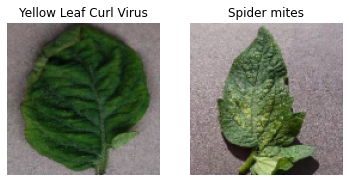

In [111]:
dls.train.show_batch(max_n=2)

In [6]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [101]:
model = xresnet18(n_out=dls.c)

In [10]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0006918309954926372)

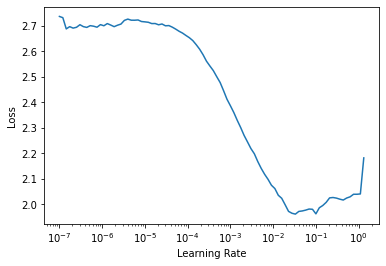

In [11]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(15, 3.331e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.565282,1.253933,0.670705,00:49
1,0.790432,0.562312,0.852974,00:49
2,0.465332,0.361460,0.880690,00:49
3,0.322803,0.312935,0.894457,00:49
4,0.251931,0.199548,0.937225,00:49
5,0.197743,0.162105,0.946953,00:49
6,0.170126,0.131778,0.954295,00:49
7,0.140545,0.108637,0.964758,00:49
8,0.121761,0.093810,0.967695,00:49
9,0.095934,0.104166,0.963840,00:49


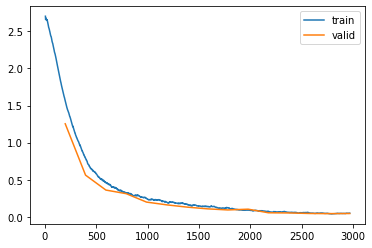

In [18]:
learn.recorder.plot_loss()

## Presizing

In [15]:
learn.dls = get_dls(25, 400)

In [19]:
learn.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.609011,0.615436,0.805617,04:50


epoch,train_loss,valid_loss,accuracy,time
0,0.282624,0.335905,0.880690,04:49
1,0.330437,0.253797,0.912996,04:49
2,0.210881,0.224447,0.920521,04:48
3,0.153148,0.176540,0.933003,04:49
4,0.122554,0.084037,0.973568,04:49
5,0.067954,0.050841,0.982562,04:49
6,0.045170,0.038966,0.987151,04:49


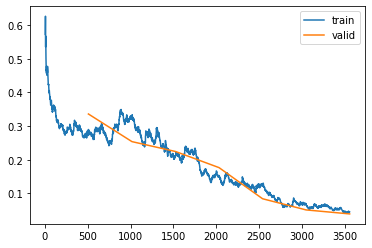

In [20]:
learn.recorder.plot_loss()

### Evaluating using Test Time Augmentation method

In [22]:
pred, targ = learn.tta()

In [25]:
# Test time augmentation accuracy level 
accuracy(pred, targ).item()

0.9911894202232361

#### Sample from local file

In [26]:
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [27]:
img = PILImage.create(upload.data[0])

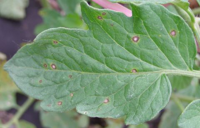

In [31]:
img.to_thumb(200)

In [32]:
learn.predict(img)

('Septoria leaf spot',
 tensor(6),
 tensor([2.5699e-03, 7.4574e-02, 2.7623e-08, 3.0057e-03, 7.8944e-09, 4.5629e-15,
         9.1983e-01, 1.0482e-16, 1.6376e-05, 2.5632e-10]))

#### Model save

In [34]:
path_save = Path.cwd()/"../models/tomato.pkl"
learn.export(path_save)

In [35]:
l = load_learner(path_save)
l.predict(img)

('Septoria leaf spot',
 tensor(6),
 tensor([2.5699e-03, 7.4574e-02, 2.7623e-08, 3.0058e-03, 7.8945e-09, 4.5630e-15,
         9.1983e-01, 1.0482e-16, 1.6376e-05, 2.5632e-10]))

## Mixup with Label Smoothing

In [9]:
learn = Learner(dls, xresnet18(), loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=MixUp())

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.002511886414140463)

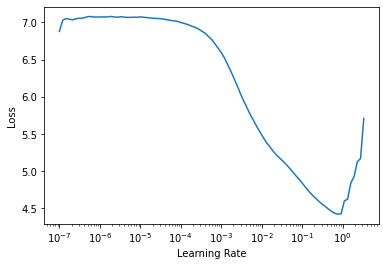

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(25, 7.58e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.030379,1.675418,0.773128,00:40
1,1.985784,2.805551,0.497797,00:39
2,1.904006,1.798723,0.725404,00:40
3,1.890079,1.803425,0.708884,00:40
4,1.873033,1.604965,0.803231,00:40
5,1.820380,1.718807,0.742291,00:40
6,1.765046,1.377982,0.881057,00:40
7,1.741843,1.927669,0.659692,00:40
8,1.729037,1.420102,0.875184,00:39
9,1.712659,1.647049,0.838473,00:39


In [12]:
learn.validate()

(#2) [1.052466630935669,0.9944933652877808]

In [16]:
learn.dls = get_dls(64, 256)

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.604938,1.515477,0.881791,01:57
1,1.543810,1.376759,0.912628,01:55
2,1.540247,1.371455,0.915932,01:56
3,1.552670,1.419293,0.910059,01:55


In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.531899,1.296998,0.935022,01:54
1,1.523115,1.266104,0.933554,01:55
2,1.538547,1.197434,0.951542,01:55
3,1.523967,1.123520,0.975404,01:56
4,1.515572,1.188399,0.952643,01:55
5,1.491300,1.198125,0.944934,01:56
6,1.500772,1.095187,0.983847,01:55
7,1.478496,1.097383,0.978708,01:55
8,1.473482,1.113138,0.976138,01:55
9,1.467065,1.086761,0.983847,01:56


In [20]:
pred, targ = learn.tta()

In [22]:
accuracy(pred, targ).item()

0.9985315799713135